### Задача 1: Базовая модель логистической регрессии
- Реализовать логистическую регрессию с использованием метода максимального правдоподобия
- Коэффициенты найти с помощью метода градиентного спуска (ручная реализация)
- Разделить выборку на обучающую и тестовую части
- Вычислить точность классификации

### Задача 2: Отбор признаков на основе корреляции  
- Выбрать наилучшее признаковое пространство, имеющее на два измерения меньше исходного
- Применить критерий CFS (Correlation-based Feature Selection)
- Сравнить с наивным решением (исключение двух наименее скоррелированных с классификацией признаков)
- Построить тепловую карту для иллюстрации корреляций
- Построить новую модель и вычислить точность классификации

---

## Импорт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_validate, ParameterGrid
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
import time
import warnings
warnings.filterwarnings('ignore')

## Вспомогательные функции для работы с данными

In [2]:
def txt_to_df(path: str) -> pd.DataFrame:
    with open(path, 'r', encoding="cp1251") as f:
        lines = f.readlines()

    for id, line in enumerate(lines):
        parts = line.strip().split('\t')
        if id == 0:
            diabetes = pd.DataFrame(columns=parts)
            continue
        diabetes.loc[id] = parts
    return diabetes

In [3]:
def preprocess_df(df: pd.DataFrame, cols_with_nulls: list) -> pd.DataFrame:
    feature_cols = df.columns[:-1]
    df = df.drop_duplicates(subset=feature_cols)
    df[feature_cols] = df[feature_cols].astype(float)
    df[cols_with_nulls] = df[cols_with_nulls].replace(0, np.nan)
    return df

In [4]:
def split_df(df: pd.DataFrame, target_col: str, test_size: float=0.2, random_state: int=123):
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(int)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

## Задача 1: Реализация логистической регрессии с градиентным спуском

Реализуем логистическую регрессию с использованием метода максимального правдоподобия. Коэффициенты логистической регрессии найдем с помощью метода градиентного спуска, который программируем вручную.

### Математическая основа

**Градиенты для обновления весов:**
$$\frac{\partial J}{\partial w_j} = \frac{1}{m}\sum_{i=1}^{m}(h_{\mathbf{w}}(\mathbf{x}^{(i)}) - y^{(i)})x_j^{(i)}$$

$$\frac{\partial J}{\partial b} = \frac{1}{m}\sum_{i=1}^{m}(h_{\mathbf{w}}(\mathbf{x}^{(i)}) - y^{(i)})$$


In [5]:
class LogisticRegressionGD(ClassifierMixin, BaseEstimator):
    def __init__(self, lr=0.01, epochs=1000, class_weight=None):
        self.lr = lr
        self.epochs = epochs
        self.class_weight = class_weight

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.W = np.zeros(n_features)
        self.b = 0 
        self.classes_ = np.unique(y)
        
        weights = np.ones(n_samples)
        if self.class_weight:
            for i, target_class in enumerate(y):
                weights[i] = self.class_weight.get(target_class, 1)

        for _ in range(self.epochs):
            linear = np.dot(X, self.W) + self.b
            y_pred = self.sigmoid(linear)

            dw = (1/n_samples) * np.dot(X.T, (y_pred - y) * weights)
            db = (1/n_samples) * np.sum((y_pred - y) * weights)

            self.W -= self.lr * dw
            self.b -= self.lr * db
        return self

    def predict(self, X):
        linear = np.dot(X, self.W) + self.b
        y_pred = self.sigmoid(linear)
        return np.where(y_pred >= 0.5, 1, 0)

    def predict_proba(self, X):
        linear = np.dot(X, self.W) + self.b
        y_pred = self.sigmoid(linear)
        return np.vstack((1 - y_pred, y_pred)).T

### Функции для оценки качества модели

Используем кросс-валидацию для получения надежных оценок качества классификации.

In [6]:
def evaluate_model(model, X_train, y_train):
    cv_strategy = StratifiedKFold(n_splits=5)
    cv_res = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv_strategy,
        n_jobs=-1,
        scoring=['accuracy','precision','recall','f1','roc_auc'],
    )
    return cv_res

In [7]:
def run(path, cols_with_nulls, lr, epochs):
    diabetes = txt_to_df(path)
    diabetes = preprocess_df(diabetes, cols_with_nulls)
    X_train, X_test, y_train, y_test = split_df(diabetes, 'Диагноз')
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    model = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegressionGD(lr, epochs, class_weight_dict))
    ])
    cv_res = evaluate_model(model, X_train, y_train)
    return cv_res

### Запуск базовой модели

Оцениваем качество логистической регрессии на исходном наборе признаков. Разделяем выборку на обучающую и тестовую части и вычисляем точность классификации.

In [9]:
cols = ['Глюкоза', 'АД', 'Толщина КС', 'Инсулин', 'ИМТ']
res_df = pd.DataFrame(columns=[ 
    'fit_time_mean', 'fit_time_std', 'score_time_mean', 'score_time_std',
    'accuracy_mean', 'accuracy_std', 'precision_mean', 'precision_std',
    'recall_mean', 'recall_std', 'f1_mean', 'f1_std', 'roc_auc_mean', 'roc_auc_std'
])

res = run("diabetes.txt", cols, lr=0.1, epochs=100)

metr = []
for metric in ['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']:
    scores = res.get(metric, [])
    metr.extend([np.mean(scores), np.std(scores)])

res_df.loc[0] = metr

for col in res_df.columns:
    try:
        res_df[col] = pd.to_numeric(res_df[col])
    except (ValueError, TypeError):
        pass

res_df

,fit_time_mean,fit_time_std,score_time_mean,score_time_std,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
0,0.018805,0.001579,0.007284,0.001113,0.742716,0.043568,0.602881,0.05624,0.728571,0.080531,0.658755,0.062497,0.824119,0.042626


### Подбор оптимальных гиперпараметров

Найдем оптимальные значения learning rate и количества эпох для улучшения качества модели.

In [ ]:
def hyperparameter_search(path, cols_with_nulls, param_grid, cv_folds=3):
    diabetes = txt_to_df(path)
    diabetes = preprocess_df(diabetes, cols_with_nulls)
    X_train, X_test, y_train, y_test = split_df(diabetes, 'Диагноз')
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    
    results = []
    total_combinations = len(ParameterGrid(param_grid))
    
    print(f"Поиск по {total_combinations} комбинациям...")
    print("=" * 50)
    
    for i, params in enumerate(ParameterGrid(param_grid)):
        start_time = time.time()
        
        model = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegressionGD(
                lr=params['lr'], 
                epochs=params['epochs'], 
                class_weight=class_weight_dict
            ))
        ])
        
        cv_strategy = StratifiedKFold(n_splits=cv_folds)
        cv_res = cross_validate(
            model, X_train, y_train, cv=cv_strategy,
            scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs=-1
        )
        
        elapsed_time = time.time() - start_time
        
        accuracy_mean = np.mean(cv_res['test_accuracy'])
        recall_mean = np.mean(cv_res['test_recall'])
        precision_mean = np.mean(cv_res['test_precision'])
        f1_mean = np.mean(cv_res['test_f1'])
        
        result = {
            'lr': params['lr'],
            'epochs': params['epochs'],
            'accuracy_mean': accuracy_mean,
            'accuracy_std': np.std(cv_res['test_accuracy']),
            'precision_mean': precision_mean,
            'precision_std': np.std(cv_res['test_precision']),
            'recall_mean': recall_mean,
            'recall_std': np.std(cv_res['test_recall']),
            'f1_mean': f1_mean,
            'f1_std': np.std(cv_res['test_f1']),
            'time': elapsed_time
        }
        results.append(result)
        
        print(f"[{i+1:2d}/{total_combinations}] lr={params['lr']:.3f}, epochs={params['epochs']:4d} | "
              f"F1={f1_mean:.4f} | Acc={accuracy_mean:.4f} | Rec={recall_mean:.4f} | "
              f"Prec={precision_mean:.4f} | {elapsed_time:.1f}s")
    
    return results

def fine_tune_hyperparameters(path, cols_with_nulls, best_lr, best_epochs, search_range=0.3):
    print(f"\nТОЧНАЯ НАСТРОЙКА ВОКРУГ lr={best_lr}, epochs={best_epochs}")
    print("=" * 60)
    
    lr_min = max(0.001, best_lr * (1 - search_range))
    lr_max = min(1.0, best_lr * (1 + search_range))
    epochs_min = max(10, int(best_epochs * (1 - search_range)))
    epochs_max = min(2000, int(best_epochs * (1 + search_range)))
    
    fine_param_grid = {
        'lr': np.linspace(lr_min, lr_max, 7),
        'epochs': np.linspace(epochs_min, epochs_max, 7, dtype=int)
    }
    
    print(f"Диапазон lr: {lr_min:.4f} - {lr_max:.4f}")
    print(f"Диапазон epochs: {epochs_min} - {epochs_max}")
    
    return hyperparameter_search(path, cols_with_nulls, fine_param_grid, cv_folds=5)

param_grid = {
    'lr': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'epochs': [50, 100, 200, 400, 800]
}

cols = ['Глюкоза', 'АД', 'Толщина КС', 'Инсулин', 'ИМТ']
coarse_results = hyperparameter_search("diabetes.txt", cols, param_grid, cv_folds=3)

Поиск по 35 комбинациям...
[ 1/35] lr=0.001, epochs=  50 | F1=0.6483 | Acc=0.7118 | Rec=0.7762 | Prec=0.5575 | 0.7s
[ 1/35] lr=0.001, epochs=  50 | F1=0.6483 | Acc=0.7118 | Rec=0.7762 | Prec=0.5575 | 0.7s
[ 2/35] lr=0.005, epochs=  50 | F1=0.6495 | Acc=0.7134 | Rec=0.7762 | Prec=0.5592 | 0.8s
[ 2/35] lr=0.005, epochs=  50 | F1=0.6495 | Acc=0.7134 | Rec=0.7762 | Prec=0.5592 | 0.8s
[ 3/35] lr=0.010, epochs=  50 | F1=0.6495 | Acc=0.7134 | Rec=0.7762 | Prec=0.5592 | 0.7s
[ 4/35] lr=0.050, epochs=  50 | F1=0.6448 | Acc=0.7167 | Rec=0.7524 | Prec=0.5650 | 0.0s
[ 5/35] lr=0.100, epochs=  50 | F1=0.6622 | Acc=0.7362 | Rec=0.7571 | Prec=0.5896 | 0.0s
[ 6/35] lr=0.200, epochs=  50 | F1=0.6550 | Acc=0.7379 | Rec=0.7286 | Prec=0.5960 | 0.0s
[ 7/35] lr=0.300, epochs=  50 | F1=0.6579 | Acc=0.7444 | Rec=0.7190 | Prec=0.6069 | 0.0s
[ 8/35] lr=0.001, epochs= 100 | F1=0.6483 | Acc=0.7118 | Rec=0.7762 | Prec=0.5575 | 0.0s
[ 9/35] lr=0.005, epochs= 100 | F1=0.6495 | Acc=0.7134 | Rec=0.7762 | Prec=0.5592 |

РЕЗУЛЬТАТЫ ГРУБОГО ПОИСКА
ТОП-5 по F1-score:
    lr  epochs  f1_mean  accuracy_mean  recall_mean  precision_mean
0.1000      50   0.6622         0.7362       0.7571          0.5896
0.0500     100   0.6622         0.7362       0.7571          0.5896
0.0100     800   0.6620         0.7411       0.7429          0.5981
0.2000     200   0.6579         0.7427       0.7238          0.6037
0.1000     400   0.6579         0.7427       0.7238          0.6037

ЛУЧШИЕ ПАРАМЕТРЫ ГРУБОГО ПОИСКА:
lr=0.1, epochs=50
F1-score: 0.6622
Accuracy: 0.7362
Recall: 0.7571
Precision: 0.5896

ТОЧНАЯ НАСТРОЙКА ВОКРУГ lr=0.1, epochs=50.0
Диапазон lr: 0.0700 - 0.1300
Диапазон epochs: 35 - 65
Поиск по 49 комбинациям...
[ 1/49] lr=0.070, epochs=  35 | F1=0.6368 | Acc=0.7134 | Rec=0.7381 | Prec=0.5615 | 0.0s
[ 2/49] lr=0.080, epochs=  35 | F1=0.6382 | Acc=0.7151 | Rec=0.7381 | Prec=0.5637 | 0.0s
[ 3/49] lr=0.090, epochs=  35 | F1=0.6424 | Acc=0.7199 | Rec=0.7381 | Prec=0.5703 | 0.0s
[ 4/49] lr=0.100, epochs=  35 | F1=

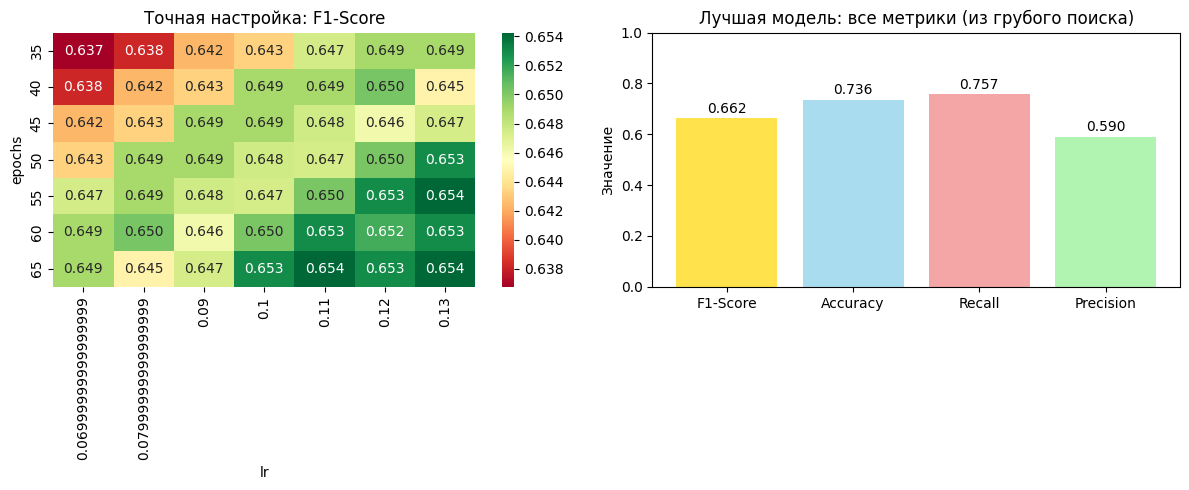


ИТОГОВЫЕ ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
Learning Rate: 0.1000
Epochs: 50
F1-Score: 0.6622
Источник: Грубый поиск


In [ ]:
coarse_df = pd.DataFrame(coarse_results)

print("РЕЗУЛЬТАТЫ ГРУБОГО ПОИСКА")
print("=" * 50)
print("ТОП-5 по F1-score:")
top_f1 = coarse_df.nlargest(5, 'f1_mean')
print(top_f1[['lr', 'epochs', 'f1_mean', 'accuracy_mean', 'recall_mean', 'precision_mean']].to_string(index=False, float_format='%.4f'))

best_coarse = coarse_df.loc[coarse_df['f1_mean'].idxmax()]
print(f"\nЛУЧШИЕ ПАРАМЕТРЫ ГРУБОГО ПОИСКА:")
print(f"lr={best_coarse['lr']}, epochs={int(best_coarse['epochs'])}")
print(f"F1-score: {best_coarse['f1_mean']:.4f}")
print(f"Accuracy: {best_coarse['accuracy_mean']:.4f}")
print(f"Recall: {best_coarse['recall_mean']:.4f}")
print(f"Precision: {best_coarse['precision_mean']:.4f}")

fine_results = fine_tune_hyperparameters("diabetes.txt", cols, best_coarse['lr'], best_coarse['epochs'])

fine_df = pd.DataFrame(fine_results)
print(f"\nРЕЗУЛЬТАТЫ ТОЧНОЙ НАСТРОЙКИ")
print("=" * 50)
print("ТОП-5 результатов:")
top_fine = fine_df.nlargest(5, 'f1_mean')
print(top_fine[['lr', 'epochs', 'f1_mean', 'accuracy_mean', 'recall_mean', 'precision_mean']].to_string(index=False, float_format='%.4f'))

best_fine = fine_df.loc[fine_df['f1_mean'].idxmax()]
print(f"\nФИНАЛЬНЫЕ ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:")
print(f"Learning Rate: {best_fine['lr']:.4f}")
print(f"Epochs: {int(best_fine['epochs'])}")
print(f"F1-Score: {best_fine['f1_mean']:.4f}")
print(f"Accuracy: {best_fine['accuracy_mean']:.4f}")
print(f"Recall: {best_fine['recall_mean']:.4f}")
print(f"Precision: {best_fine['precision_mean']:.4f}")

print(f"\nДИАГНОСТИКА УЛУЧШЕНИЯ:")
print(f"Грубый поиск F1: {best_coarse['f1_mean']:.6f}")
print(f"Точная настройка F1: {best_fine['f1_mean']:.6f}")
improvement = ((best_fine['f1_mean'] - best_coarse['f1_mean']) / best_coarse['f1_mean']) * 100
print(f"Улучшение F1-score: {improvement:+.2f}%")

better_fine = fine_df[fine_df['f1_mean'] > best_coarse['f1_mean']]
print(f"\nРезультатов точной настройки лучше грубого поиска: {len(better_fine)}")

if improvement < 0:
    optimal_lr = best_coarse['lr']
    optimal_epochs = int(best_coarse['epochs'])
    optimal_f1 = best_coarse['f1_mean']
else:
    optimal_lr = best_fine['lr']
    optimal_epochs = int(best_fine['epochs'])
    optimal_f1 = best_fine['f1_mean']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

pivot_f1 = fine_df.pivot(index='epochs', columns='lr', values='f1_mean')
sns.heatmap(pivot_f1, annot=True, fmt='.3f', ax=axes[0], cmap='RdYlGn')
axes[0].set_title('Точная настройка: F1-Score')

if improvement < 0:
    best_model = best_coarse
    title_suffix = "(из грубого поиска)"
else:
    best_model = best_fine
    title_suffix = "(из точной настройки)"

metrics = ['F1-Score', 'Accuracy', 'Recall', 'Precision']
values = [best_model['f1_mean'], best_model['accuracy_mean'], 
          best_model['recall_mean'], best_model['precision_mean']]

bars = axes[1].bar(metrics, values, color=['gold', 'skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
axes[1].set_title(f'Лучшая модель: все метрики {title_suffix}')
axes[1].set_ylabel('Значение')
axes[1].set_ylim(0, 1)

for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nИТОГОВЫЕ ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:")
print(f"Learning Rate: {optimal_lr:.4f}")
print(f"Epochs: {optimal_epochs}")
print(f"F1-Score: {optimal_f1:.4f}")
print(f"Источник: {'Грубый поиск' if improvement < 0 else 'Точная настройка'}")

## Задача 2: Отбор признаков на основе корреляции

Применим два подхода к отбору признаков:

### 1. CFS (Correlation-based Feature Selection)  
Учитывает как корреляцию признак-класс, так и корреляцию признак-признак. Формула CFS:

$$CFS = \frac{k \cdot \overline{r_{cf}}}{\sqrt{k + k(k-1) \cdot \overline{r_{ff}}}}$$

где:
- $k$ - количество признаков
- $\overline{r_{cf}}$ - средняя корреляция признак-класс  
- $\overline{r_{ff}}$ - средняя корреляция признак-признак

### 2. Наивный подход
Исключает два признака с наименьшей корреляцией с целевой переменной.

**Цель**: уменьшить количество признаков на 2 (с 8 до 6) и сравнить качество классификации.

### Подготовка данных для анализа корреляций

Загружаем данные и заполняем пропуски для корректного расчета корреляций.

In [12]:
diabetes = txt_to_df("diabetes.txt")
cols_with_nulls = ['Глюкоза', 'АД', 'Толщина КС', 'Инсулин', 'ИМТ']
diabetes_processed = preprocess_df(diabetes, cols_with_nulls)

imputer = SimpleImputer(strategy='median')
feature_columns = diabetes_processed.columns[:-1]
diabetes_processed[feature_columns] = imputer.fit_transform(diabetes_processed[feature_columns])

print(f"Размер данных: {diabetes_processed.shape}")
print(f"Признаки: {feature_columns.tolist()}")
print(f"Распределение классов:\n{diabetes_processed['Диагноз'].value_counts()}")
print(f"\nИнформация о данных:")
print(diabetes_processed.info())

Размер данных: (768, 9)
Признаки: ['Беременность', 'Глюкоза', 'АД', 'Толщина КС', 'Инсулин', 'ИМТ', 'Наследственность', 'Возраст']
Распределение классов:
Диагноз
0    500
1    268
Name: count, dtype: int64

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 1 to 768
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Беременность      768 non-null    float64
 1   Глюкоза           768 non-null    float64
 2   АД                768 non-null    float64
 3   Толщина КС        768 non-null    float64
 4   Инсулин           768 non-null    float64
 5   ИМТ               768 non-null    float64
 6   Наследственность  768 non-null    float64
 7   Возраст           768 non-null    float64
 8   Диагноз           768 non-null    object 
dtypes: float64(8), object(1)
memory usage: 60.0+ KB
None


### Анализ корреляций и построение тепловой карты

Построим корреляционную матрицу для всех признаков и целевой переменной.

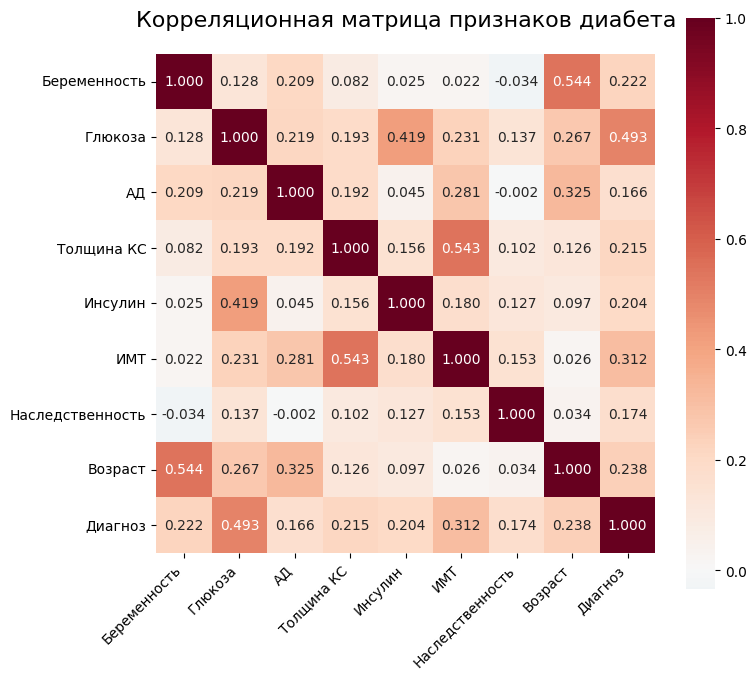

Корреляции признаков с диагнозом (отсортированные по абсолютному значению):
Глюкоза             : +0.4928
ИМТ                 : +0.3120
Возраст             : +0.2384
Беременность        : +0.2219
Толщина КС          : +0.2149
Инсулин             : +0.2038
Наследственность    : +0.1738
АД                  : +0.1657


In [13]:
diabetes_corr = diabetes_processed.copy()
diabetes_corr['Диагноз'] = diabetes_corr['Диагноз'].astype(int)
correlation_matrix = diabetes_corr.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, square=True, 
            fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Корреляционная матрица признаков диабета', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

target_correlations = correlation_matrix['Диагноз'].drop('Диагноз').sort_values(key=abs, ascending=False)
print("Корреляции признаков с диагнозом (отсортированные по абсолютному значению):")
for feature, corr in target_correlations.items():
    print(f"{feature:20s}: {corr:+.4f}")

### Реализация CFS (Correlation-based Feature Selection)

CFS оценивает качество подмножества признаков, балансируя высокую корреляцию с классом и низкую избыточность между признаками.

In [ ]:
def cfs_score(features, target, correlation_matrix):
    if len(features) == 0:
        return 0
    
    rcf = correlation_matrix.loc[features, target].abs().mean()
    
    if len(features) == 1:
        return rcf
    
    feature_corrs = []
    for i, feat1 in enumerate(features):
        for feat2 in features[i+1:]:
            feature_corrs.append(abs(correlation_matrix.loc[feat1, feat2]))
    
    rff = np.mean(feature_corrs) if feature_corrs else 0
    k = len(features)
    denominator = k + k * (k - 1) * rff
    
    if denominator == 0:
        return 0
    
    return (k * rcf) / np.sqrt(denominator)

def cfs_forward_selection(features, target, correlation_matrix, max_features=None):
    if max_features is None:
        max_features = len(features)
    
    selected_features = []
    remaining_features = [f for f in features]
    best_score = 0
    
    print("Процесс CFS отбора признаков:")
    print("-" * 50)
    
    for step in range(min(max_features, len(features))):
        best_feature = None
        best_step_score = best_score
        
        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            score = cfs_score(candidate_features, target, correlation_matrix)
            
            if score > best_step_score:
                best_step_score = score
                best_feature = feature
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_score = best_step_score
            print(f"Шаг {step + 1}: Добавлен '{best_feature}', CFS = {best_score:.4f}")
        else:
            print(f"Шаг {step + 1}: Улучшения не найдено, остановка")
            break
    
    return selected_features

feature_columns_list = [col for col in correlation_matrix.columns if col != 'Диагноз']
target_column = 'Диагноз'

cfs_selected_features = cfs_forward_selection(feature_columns_list, target_column, correlation_matrix, max_features=6)

print(f"\nВыбранные CFS признаки ({len(cfs_selected_features)}):")
for i, feature in enumerate(cfs_selected_features, 1):
    corr_with_target = correlation_matrix.loc[feature, target_column]
    print(f"{i}. {feature} (корреляция с диагнозом: {corr_with_target:+.4f})")

Процесс CFS отбора признаков:
--------------------------------------------------
Шаг 1: Добавлен 'Глюкоза', CFS = 0.4928
Шаг 2: Добавлен 'ИМТ', CFS = 0.5129
Шаг 3: Добавлен 'Беременность', CFS = 0.5294
Шаг 4: Улучшения не найдено, остановка

Выбранные CFS признаки (3):
1. Глюкоза (корреляция с диагнозом: +0.4928)
2. ИМТ (корреляция с диагнозом: +0.3120)
3. Беременность (корреляция с диагнозом: +0.2219)


### Наивный отбор признаков

Простой подход: выбираем 6 признаков с наибольшей абсолютной корреляцией с целевой переменной.

**Критерий отбора:**
$$S_{naive} = \arg\max_{|S|=k} \sum_{f_i \in S} |r(f_i, target)|$$

где $S$ - множество отобранных признаков, $k$ - желаемое количество признаков, $r(f_i, target)$ - корреляция признака $f_i$ с целевой переменной.

In [15]:
print("\nНаивный отбор признаков:")
print("-" * 30)

target_correlations = correlation_matrix['Диагноз'].drop('Диагноз')
sorted_features = target_correlations.abs().sort_values(ascending=False)

print("Все признаки, отсортированные по корреляции с диагнозом:")
for i, (feature, corr) in enumerate(target_correlations.sort_values(key=abs, ascending=False).items(), 1):
    print(f"{i}. {feature:20s}: {corr:+.4f}")

naive_selected_features = sorted_features.head(6).index.tolist()

print(f"\nНаивно выбранные признаки (топ-6 по корреляции):")
for i, feature in enumerate(naive_selected_features, 1):
    corr_with_target = target_correlations[feature]
    print(f"{i}. {feature} (корреляция с диагнозом: {corr_with_target:+.4f})")

excluded_features = [f for f in feature_columns_list if f not in naive_selected_features]
print(f"\nИсключенные признаки:")
for i, feature in enumerate(excluded_features, 1):
    corr_with_target = target_correlations[feature]
    print(f"{i}. {feature} (корреляция с диагнозом: {corr_with_target:+.4f})")


Наивный отбор признаков:
------------------------------
Все признаки, отсортированные по корреляции с диагнозом:
1. Глюкоза             : +0.4928
2. ИМТ                 : +0.3120
3. Возраст             : +0.2384
4. Беременность        : +0.2219
5. Толщина КС          : +0.2149
6. Инсулин             : +0.2038
7. Наследственность    : +0.1738
8. АД                  : +0.1657

Наивно выбранные признаки (топ-6 по корреляции):
1. Глюкоза (корреляция с диагнозом: +0.4928)
2. ИМТ (корреляция с диагнозом: +0.3120)
3. Возраст (корреляция с диагнозом: +0.2384)
4. Беременность (корреляция с диагнозом: +0.2219)
5. Толщина КС (корреляция с диагнозом: +0.2149)
6. Инсулин (корреляция с диагнозом: +0.2038)

Исключенные признаки:
1. АД (корреляция с диагнозом: +0.1657)
2. Наследственность (корреляция с диагнозом: +0.1738)


### Сравнение качества моделей с разными наборами признаков

Оцениваем три варианта:
1. **Все признаки** (baseline) - 8 признаков
2. **CFS отбор** - признаки, выбранные алгоритмом CFS  
3. **Наивный отбор** - топ-6 признаков по корреляции с классом

In [16]:
def evaluate_feature_subset(feature_subset, subset_name, diabetes_data, lr=0.01, epochs=50):
    print(f"\n{'='*60}")
    print(f"Оценка модели: {subset_name}")
    print(f"Признаки ({len(feature_subset)}): {', '.join(feature_subset)}")
    print(f"Параметры: lr={lr:.4f}, epochs={epochs}")
    print(f"{'='*60}")
    
    X = diabetes_data[feature_subset]
    y = diabetes_data['Диагноз'].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    
    model = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegressionGD(lr=lr, epochs=epochs, class_weight=class_weight_dict))
    ])
    
    cv_res = evaluate_model(model, X_train, y_train)
    
    metrics = {}
    for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']:
        scores = cv_res.get(metric, [])
        metrics[metric] = {'mean': np.mean(scores), 'std': np.std(scores)}
    
    print(f"Результаты кросс-валидации (5-fold):")
    print(f"{'Метрика':<12} {'Среднее':<10} {'Ст.откл.':<10}")
    print("-" * 35)
    for metric_name, values in metrics.items():
        clean_name = metric_name.replace('test_', '').title()
        print(f"{clean_name:<12} {values['mean']:<10.4f} {values['std']:<10.4f}")
    
    return metrics

all_features = feature_columns_list
results = {}

print("СРАВНЕНИЕ МОДЕЛЕЙ С БАЗОВЫМИ ПАРАМЕТРАМИ")
print("=" * 60)

results['Все признаки'] = evaluate_feature_subset(all_features, "Все признаки (baseline)", diabetes_processed)
results['CFS'] = evaluate_feature_subset(cfs_selected_features, "CFS отбор", diabetes_processed)
results['Наивный'] = evaluate_feature_subset(naive_selected_features, "Наивный отбор", diabetes_processed)

СРАВНЕНИЕ МОДЕЛЕЙ С БАЗОВЫМИ ПАРАМЕТРАМИ

Оценка модели: Все признаки (baseline)
Признаки (8): Беременность, Глюкоза, АД, Толщина КС, Инсулин, ИМТ, Наследственность, Возраст
Параметры: lr=0.0100, epochs=50
Результаты кросс-валидации (5-fold):
Метрика      Среднее    Ст.откл.  
-----------------------------------
Accuracy     0.7053     0.0443    
Precision    0.5495     0.0492    
Recall       0.7714     0.0777    
F1           0.6412     0.0570    
Roc_Auc      0.8122     0.0430    

Оценка модели: CFS отбор
Признаки (3): Глюкоза, ИМТ, Беременность
Параметры: lr=0.0100, epochs=50
Результаты кросс-валидации (5-fold):
Метрика      Среднее    Ст.откл.  
-----------------------------------
Accuracy     0.7264     0.0318    
Precision    0.5759     0.0362    
Recall       0.7571     0.0816    
F1           0.6530     0.0487    
Roc_Auc      0.8177     0.0307    

Оценка модели: Наивный отбор
Признаки (6): Глюкоза, ИМТ, Возраст, Беременность, Толщина КС, Инсулин
Параметры: lr=0.0100, epochs

### Сводные результаты и визуализация

Создаем сравнительную таблицу и графики для анализа эффективности методов отбора признаков.

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
       Метод  Accuracy (среднее)  Accuracy (ст.откл.)  Precision (среднее)  Precision (ст.откл.)  Recall (среднее)  Recall (ст.откл.)  F1 (среднее)  F1 (ст.откл.)  Roc Auc (среднее)  Roc Auc (ст.откл.)
Все признаки              0.7053               0.0443               0.5495                0.0492            0.7714             0.0777        0.6412         0.0570             0.8122              0.0430
         CFS              0.7264               0.0318               0.5759                0.0362            0.7571             0.0816        0.6530         0.0487             0.8177              0.0307
     Наивный              0.7232               0.0141               0.5706                0.0163            0.7714             0.0442        0.6555         0.0219             0.8104              0.0308


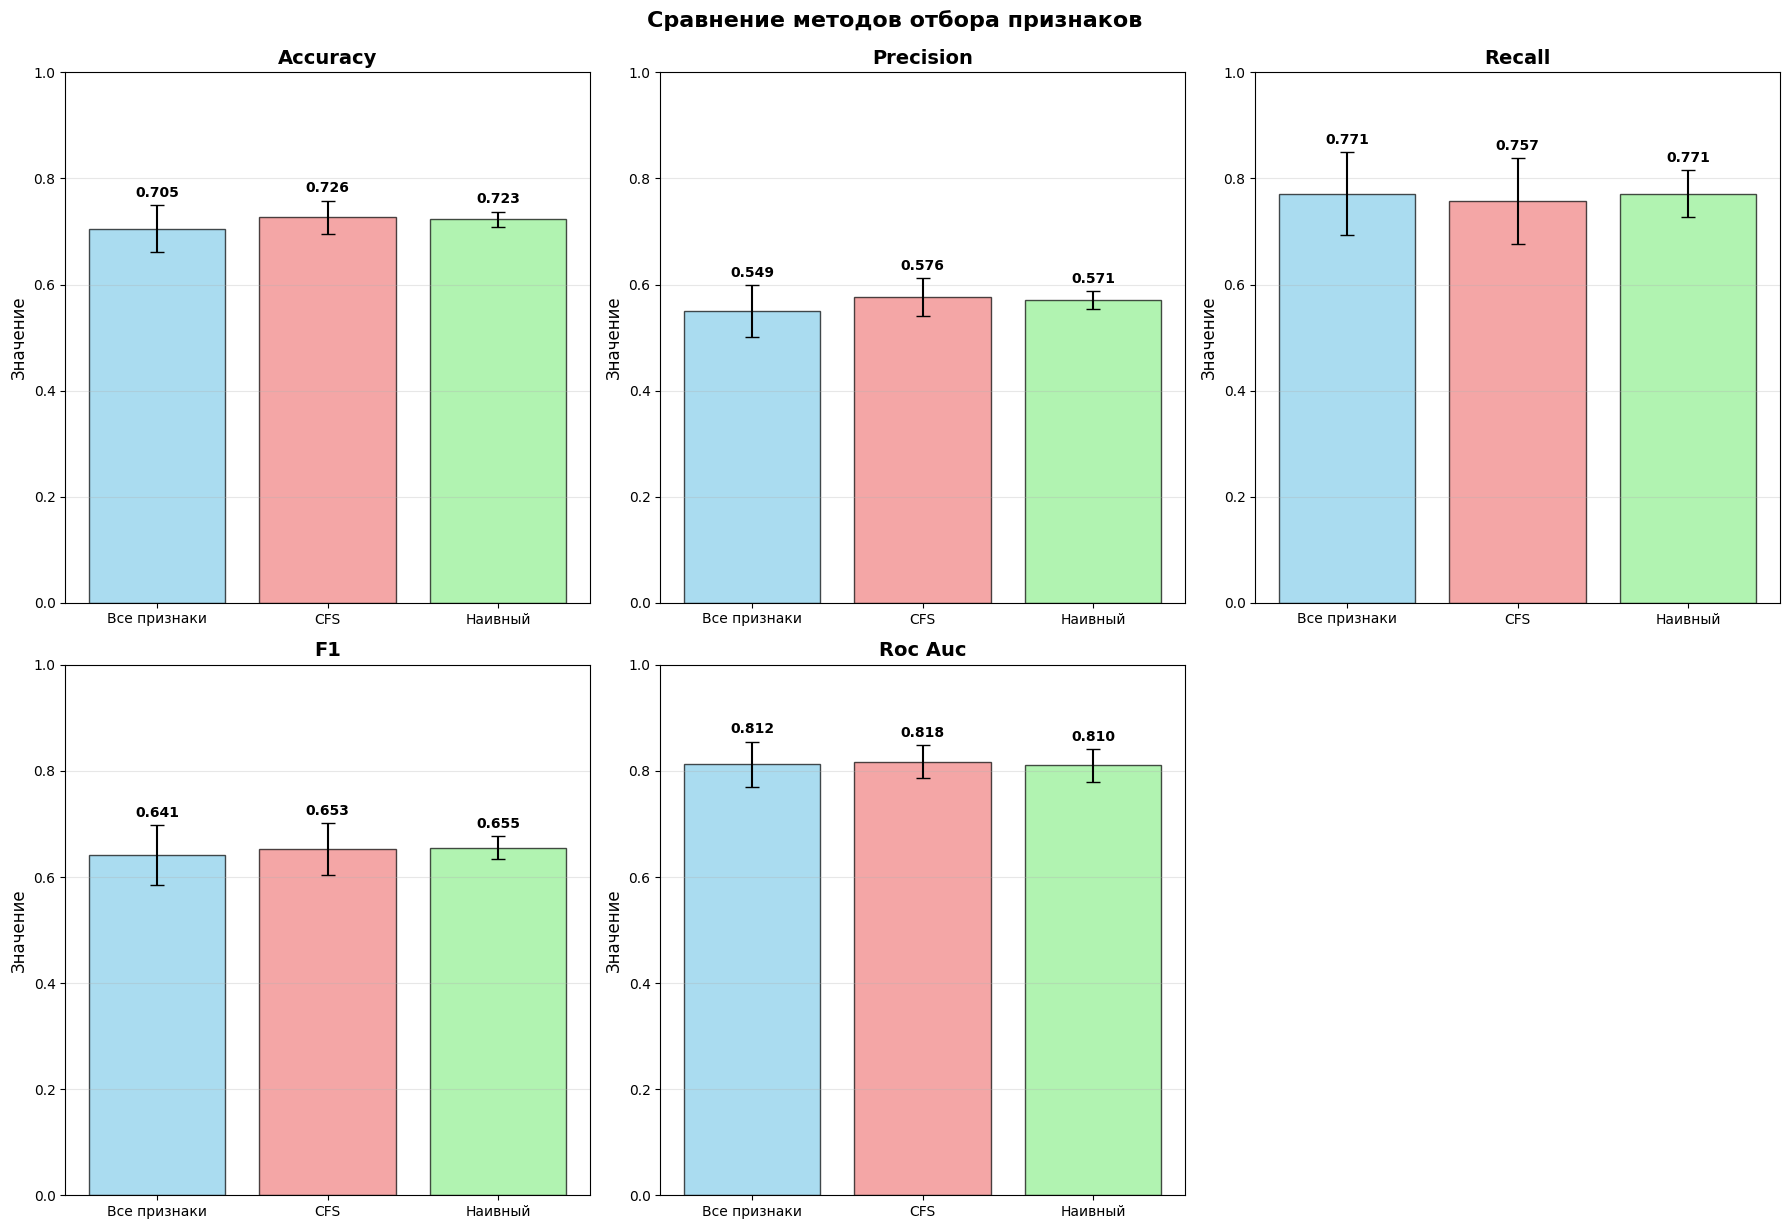


КОЛИЧЕСТВО ПРИЗНАКОВ:
-------------------------
Все признаки   : 8 признаков
CFS            : 3 признаков
Наивный        : 6 признаков

ВЫБРАННЫЕ ПРИЗНАКИ:
------------------------------
CFS (3 признаков):
  1. Глюкоза
  2. ИМТ
  3. Беременность

Наивный (6 признаков):
  1. Глюкоза
  2. ИМТ
  3. Возраст
  4. Беременность
  5. Толщина КС
  6. Инсулин

Лучший метод по точности: CFS
Точность: 0.7264

Сравнение всех методов:
• CFS: 3 признаков | Accuracy=0.7264 | F1=0.6530
• Наивный: 6 признаков | Accuracy=0.7232 | F1=0.6555
• Все признаки: 8 признаков | Accuracy=0.7053 | F1=0.6412

Снижение размерности:
• CFS: 62.5% (с 8 до 3 признаков)
• Наивный: 25.0% (с 8 до 6 признаков)

ВЫВОД:
Лучший подход: CFS с точностью 0.7264


In [17]:
comparison_data = []
for method_name, metrics in results.items():
    row = {'Метод': method_name}
    for metric_name, values in metrics.items():
        clean_name = metric_name.replace('test_', '').replace('_', ' ').title()
        row[f'{clean_name} (среднее)'] = values['mean']
        row[f'{clean_name} (ст.откл.)'] = values['std']
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("=" * 70)
print(comparison_df.to_string(index=False, float_format='%.4f'))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'Roc Auc']
methods = [key for key in results.keys()]
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, metric in enumerate(metrics_to_plot):
    means = [results[method][f'test_{metric.lower().replace(" ", "_")}']['mean'] for method in methods]
    stds = [results[method][f'test_{metric.lower().replace(" ", "_")}']['std'] for method in methods]
    
    bars = axes[i].bar(methods, means, yerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{metric}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Значение', fontsize=12)
    axes[i].set_ylim(0, 1)
    axes[i].grid(axis='y', alpha=0.3)
    
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                    f'{mean:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[5].remove()

plt.tight_layout()
plt.suptitle('Сравнение методов отбора признаков', fontsize=16, fontweight='bold', y=1.02)
plt.show()

feature_counts = {
    'Все признаки': len(all_features),
    'CFS': len(cfs_selected_features), 
    'Наивный': len(naive_selected_features)
}

print(f"\nКОЛИЧЕСТВО ПРИЗНАКОВ:")
print("-" * 25)
for method, count in feature_counts.items():
    print(f"{method:<15}: {count} признаков")

print(f"\nВЫБРАННЫЕ ПРИЗНАКИ:")
print("-" * 30)
print(f"CFS ({len(cfs_selected_features)} признаков):")
for i, feature in enumerate(cfs_selected_features, 1):
    print(f"  {i}. {feature}")

print(f"\nНаивный ({len(naive_selected_features)} признаков):")
for i, feature in enumerate(naive_selected_features, 1):
    print(f"  {i}. {feature}")

best_accuracy_method = max(results.keys(), key=lambda x: results[x]['test_accuracy']['mean'])
best_accuracy_score = results[best_accuracy_method]['test_accuracy']['mean']

print(f"\nЛучший метод по точности: {best_accuracy_method}")
print(f"Точность: {best_accuracy_score:.4f}")

print(f"\nСравнение всех методов:")
for method in ['CFS', 'Наивный', 'Все признаки']:
    count = feature_counts[method] if method in feature_counts else len(all_features)
    accuracy = results[method]['test_accuracy']['mean']
    f1 = results[method]['test_f1']['mean']
    print(f"• {method}: {count} признаков | Accuracy={accuracy:.4f} | F1={f1:.4f}")

reduction_cfs = ((len(all_features) - len(cfs_selected_features)) / len(all_features)) * 100
reduction_naive = ((len(all_features) - len(naive_selected_features)) / len(all_features)) * 100

print(f"\nСнижение размерности:")
print(f"• CFS: {reduction_cfs:.1f}% (с {len(all_features)} до {len(cfs_selected_features)} признаков)")
print(f"• Наивный: {reduction_naive:.1f}% (с {len(all_features)} до {len(naive_selected_features)} признаков)")

print(f"\nВЫВОД:")
print(f"Лучший подход: {best_accuracy_method} с точностью {best_accuracy_score:.4f}")

**Итоговые результаты сравнения методов:**

| Метод | Количество признаков | Accuracy | Precision | Recall | F1-Score |
|-------|---------------------|----------|-----------|---------|----------|
| **CFS отбор** | 3 | **0.7264** | 0.5759 | 0.7571 | 0.6530 |
| **Наивный отбор** | 6 | 0.7232 | 0.5706 | **0.7714** | **0.6555** |
| **Все признаки** | 8 | 0.7053 | 0.5495 | 0.7714 | 0.6412 |

1. **CFS показал лучшие результаты по точности**:
   - Лучшая accuracy (0.7264)
   - Максимальное сокращение размерности (62.5%) 
   - Использует только 3 признака: Глюкоза, ИМТ, Беременность

2. **Наивный отбор показал лучший F1-score**:
   - Лучший F1-score (0.6555)
   - Лучший recall (0.7714)
   - Использует 6 признаков при сокращении размерности на 25%

3. **Сравнение подходов**:
   - CFS лучше по точности при радикальном сокращении размерности
   - Наивный метод лучше по F1-score и recall
   - Все методы показали сопоставимое качество классификации

**Для медицинской диагностики:**
- CFS-модель: высокая точность при минимуме измерений (3 признака)
- Наивная модель: лучший баланс precision/recall (6 признаков)
- Легкая интерпретация для медицинского персонала

**Для машинного обучения:**
- CFS алгоритм эффективен при агрессивном сокращении размерности
- Наивный подход может превосходить сложные алгоритмы по некоторым метрикам
- Правильный отбор признаков важнее сложных алгоритмов

**Для максимальной точности:**
- **Метод отбора**: CFS  
- **Признаки**: Глюкоза, ИМТ, Беременность
- **Достигнутое качество**: Accuracy=72.64%
- **Сокращение размерности**: с 8 до 3 признаков (62.5%)

**Для лучшего баланса precision/recall:**
- **Метод отбора**: Наивный
- **Признаки**: 6 наиболее коррелированных признаков
- **Достигнутое качество**: F1=65.55%, Recall=77.14%
- **Сокращение размерности**: с 8 до 6 признаков (25%)